In [8]:
import numpy as np
import matplotlib.pyplot as plt

import simon_64_128
import simon_64_128_simulation
import logger
import helper

from helper import KeyHypothesis
from measurement import Measurements, Measurement


rng = np.random.default_rng()

In [2]:
NUM_MEASUREMENTS = 1000
VALS_PER_MEASUREMENT = 45
CORR_DIFF_THRESHOLD = 0.05

In [3]:
def get_x_values_from_log(log: logger.Log) -> np.ndarray:
    x_values = []
    for e in log.entries:
        if e.label.startswith("X"):
            x_values.append(e.content)
    return np.array(x_values, dtype=np.uint32)

def log_to_measurement(log: logger.Log) -> np.ndarray:
    x_values = get_x_values_from_log(log)
    return np.bitwise_count(x_values)

In [3]:
key = rng.integers(0, 2**32, 4, dtype=np.uint32)

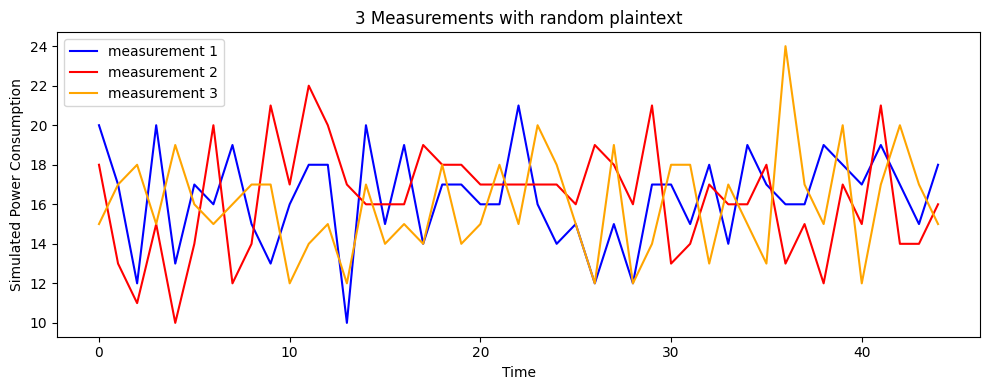

In [9]:
 # Perform 1000 simulated measurements
measurements = Measurements()

for i in range(NUM_MEASUREMENTS):
    plaintext = rng.integers(0, 2**32, 2, dtype=np.uint32)
    ciphertext, log = simon_64_128.encrypt_block(plaintext, key)
    power = simon_64_128_simulation.log_to_simulated_power(log)
    measurements.append(Measurement(plaintext, ciphertext, power))

measurements.update_power_2d()

# Draw 3 simulated traces
plt.figure(figsize=(10,4))
vals1 = measurements[0].power
vals2 = measurements[1].power
vals3 = measurements[2].power

plt.plot(vals1, color='blue', label='measurement 1')
plt.plot(vals2, color='red', label='measurement 2')
plt.plot(vals3, color='orange', label='measurement 3')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with random plaintext")
plt.tight_layout()
plt.show()


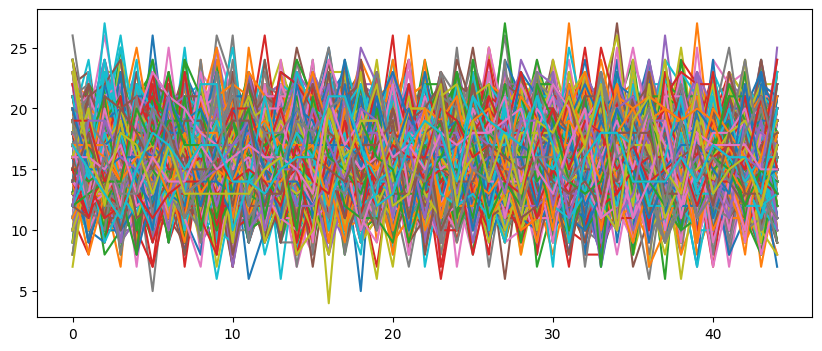

In [ ]:
# Draw all simulated traces
plt.figure(figsize=(10,4))

# Go through all measurements and get current consumption as 2D-array


x = np.arange(measurements.power_2d.shape[1])
for trace in measurements.power_2d:
    plt.plot(x, trace)

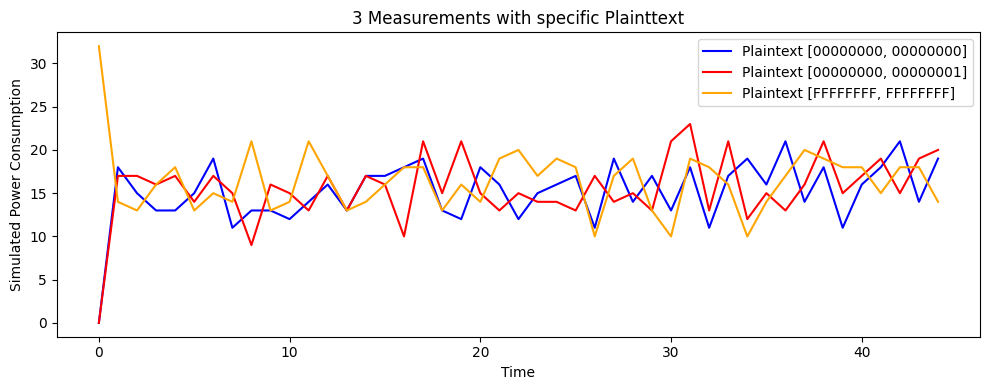

In [13]:
plaintext1 = np.array([0,0], dtype=np.uint32)
_, log1 = simon_64_128.encrypt_block(plaintext1, key)

plaintext2 = np.array([0,1], dtype=np.uint32)
_, log2 = simon_64_128.encrypt_block(plaintext2, key)

plaintext3 = np.array([0xFFFFFFFF,0xFFFFFFFF], dtype=np.uint32)
_, log3 = simon_64_128.encrypt_block(plaintext3, key)

current_consumption1 = simon_64_128_simulation.log_to_simulated_power(log1)
current_consumption2 = simon_64_128_simulation.log_to_simulated_power(log2)
current_consumption3 = simon_64_128_simulation.log_to_simulated_power(log3)

plt.figure(figsize=(10,4))
vals1 = current_consumption1
vals2 = current_consumption2
vals3 = current_consumption3

plt.plot(vals1, color='blue', label='Plaintext [00000000, 00000000]')
plt.plot(vals2, color='red', label='Plaintext [00000000, 00000001]')
plt.plot(vals3, color='orange', label='Plaintext [FFFFFFFF, FFFFFFFF]')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with specific Plainttext")
plt.tight_layout()
plt.show()

In [ ]:
def get_corr_for_hypo(hypo: helper.KeyHypothesis, measurements)

In [ ]:
# TODO: Fix this


# Go through all measurements and get current consumption as 2D-array
consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = helper.KeyHypothesis(empty_key, 0)

current_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    new_hypos: list[helper.KeyHypothesis] = []
    # Prepare a table with correlations for each possible byte value

    for h in current_hypos:
        new_hypos.extend(h.get_sub_hypos())

        for guessed_key in h.get_sub_hypotheses():

        # Go through all measurements and get expected hamming weights for guessed byte as 1D-array
        predicted_hws = np.array(
                [get_hw_for_guessed_key_byte(m[0], guessed_key, round_to_attack, byte_mask) for m in measurements], 
                dtype=np.uint32)

        # Find max correlation for current guessed byte
        max_corr_one_guess = find_best_correlation(predicted_hws, consumptions)
        key_corrs[guessed_byte] = max_corr_one_guess

    max_corr_pos = np.max(key_corrs)
    max_corr_neg = np.min(key_corrs)
    best_byte_guess_pos = np.argmax(key_corrs)
    best_byte_guess_neg = np.argmax(key_corrs)
    print(f"Best guesses for key byte {attack_idx}: 0x{best_byte_guess_pos:02X} (corr: {max_corr_pos}) and 0x{best_byte_guess_neg:02X} (corr: {max_corr_neg}). Second best correlation: {np.partition(key_corrs.flatten(), -2)[-2]}")
    current_key[key_word_idx] |= best_byte_guess_pos << byte_shift
    print(f"Current key: {array_to_hex_str(current_key)}")

print(f"Best guess for complete key: {array_to_hex_str(current_key)}")


Perform Attack Step 1/16
Best guesses for key byte 0: 0x32 (corr: 0.5088030099868774) and 0x32 (corr: -0.5088030099868774). Second best correlation: 0.4048430621623993
Current key: 0x00000000 0x00000000 0x00000000 0x00000032
Perform Attack Step 2/16
Best guesses for key byte 1: 0xFE (corr: 0.48623740673065186) and 0xFE (corr: -0.48623740673065186). Second best correlation: 0.3957687020301819
Current key: 0x00000000 0x00000000 0x00000000 0x0000FE32
Perform Attack Step 3/16
Best guesses for key byte 2: 0x15 (corr: 0.4942421317100525) and 0x15 (corr: -0.4942421317100525). Second best correlation: 0.41702911257743835
Current key: 0x00000000 0x00000000 0x00000000 0x0015FE32
Perform Attack Step 4/16
Best guesses for key byte 3: 0xCC (corr: 0.4873882234096527) and 0xCC (corr: -0.4873882234096527). Second best correlation: 0.3808385729789734
Current key: 0x00000000 0x00000000 0x00000000 0xCC15FE32
Perform Attack Step 5/16
Best guesses for key byte 4: 0xE8 (corr: 0.4949854910373688) and 0xE8 (c

In [13]:
print(f"Actual key: {array_to_hex_str(key)}")
print(f"Differences: {array_to_hex_str(current_key ^ key)}")

Actual key: 0xEF1619C3 0x7DD39CDE 0xB2C033E8 0xCC15FE32
Differences: 0x00000000 0x00000000 0x00000000 0x00000000


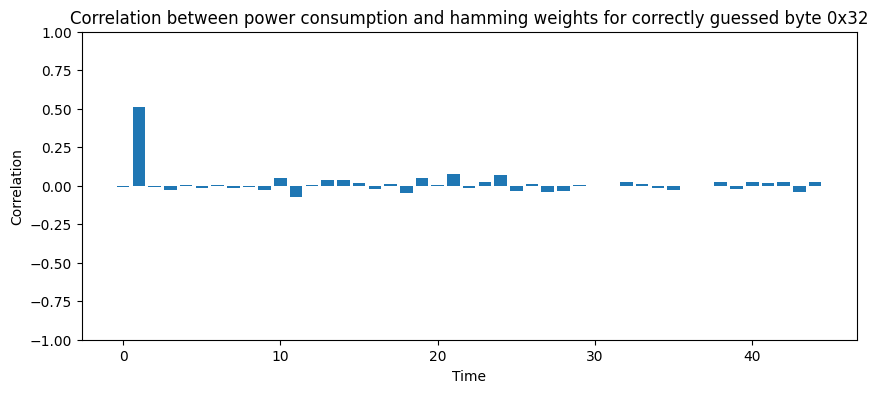

In [14]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] |= guessed_byte

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for correctly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

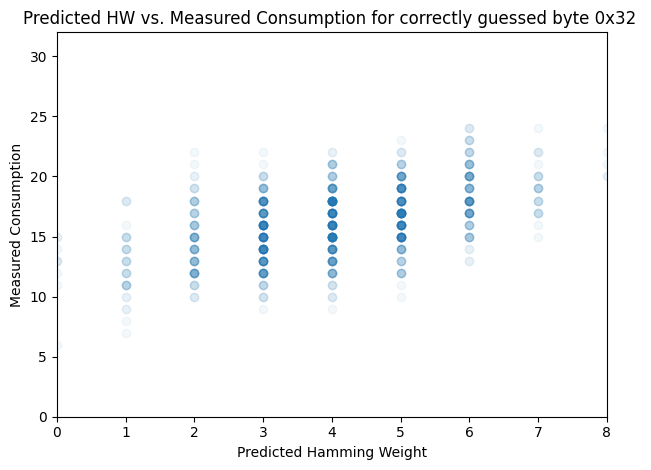

In [15]:
# Print correlation for a correct key byte

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] = key[3] & 0xFF

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

# find the index where correlation is highest
max_corr_index = np.argmax(corrs)
consumptions_with_best_corr = consumptions[:, max_corr_index]

plt.scatter(predicted_hws, consumptions_with_best_corr, alpha=0.05)
plt.xlabel("Predicted Hamming Weight")
plt.ylabel("Measured Consumption")
plt.title(f"Predicted HW vs. Measured Consumption for correctly guessed byte 0x{guessed_byte:02X} ")
plt.tight_layout()
plt.xlim(0, 8)
plt.ylim(0, 32)
plt.show()


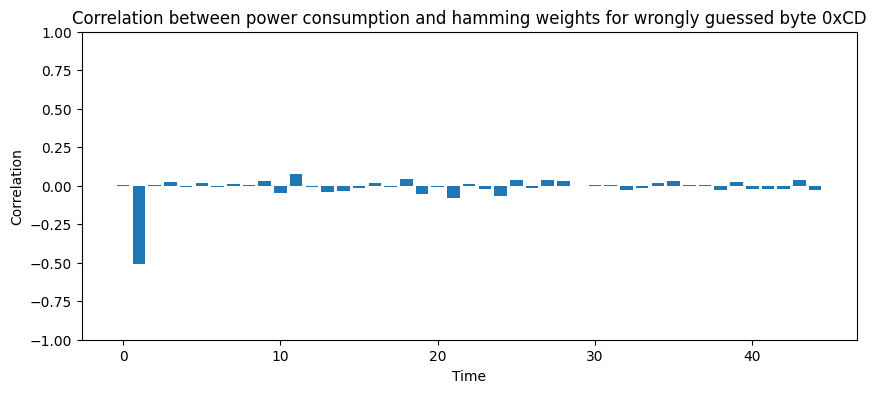

In [16]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = (~key[3] & 0xFF)
guessed_key[3] &= 0xFFFFFFFF
guessed_key[3] |= guessed_byte

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for wrongly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

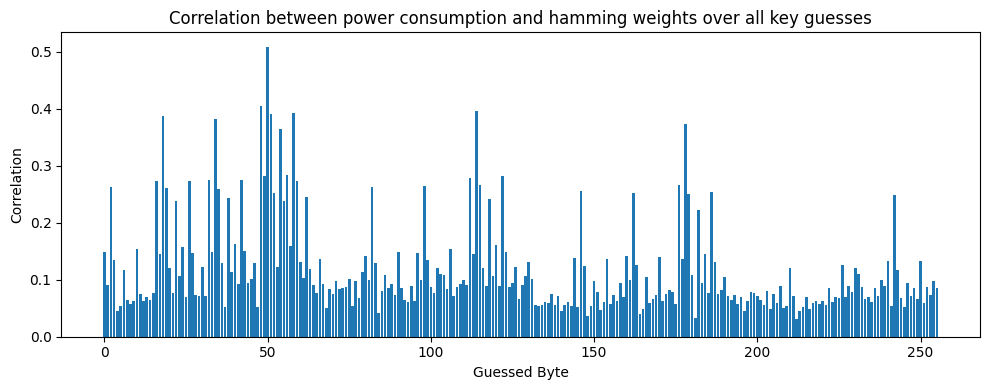

In [17]:
# Print max correlation for all guessed bytes

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

max_corrs = np.zeros((256,), dtype=np.float64)


guessed_key = np.zeros((4,), dtype=np.uint32)
for guessed_byte in range(256):
    guessed_key[3] = guessed_byte

    predicted_hws = np.array(
            [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
            dtype=np.uint32)


    corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)
    max_corrs[guessed_byte] = np.max(corrs)

plt.figure(figsize=(10,4))
x = np.arange(len(max_corrs))
plt.bar(x, max_corrs)
plt.xlabel("Guessed Byte")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights over all key guesses")
plt.tight_layout()
plt.show()